In [167]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [72]:

transform = transforms.Compose(
    [
    transforms.ToTensor()#,
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# MNIST                                           
train = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
X_train, X_val= train_test_split(
train, test_size=0.2, random_state=42)

trainLoader = torch.utils.data.DataLoader(X_train, batch_size=100,
                                          shuffle=True, num_workers=2)

validationLoader = torch.utils.data.DataLoader(X_val, batch_size=100,
                                          shuffle=True, num_workers=2)

test = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(test, batch_size=30,
                                         shuffle=False, num_workers=2)

In [68]:
X = []
Y = []

for i, data in enumerate(validationLoader, 0):
    image, label = data
    image = image.view(-1,784)
    X=image
    Y=label
    break

#     for j in range(30):
#         X.append(image[j])
#         Y.append(label[j])
# #     if i == 3:
#     break
# # for i in X

In [69]:
print(X.shape)

torch.Size([100, 784])


In [130]:
print(Y)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_2d = tsne.fit_transform(X)
#print(X_2d)
print(X_2d[2])
print(X_2d)
numbers=[0,1,2,3,4,5,6,7,8,9]

tensor([1, 6, 2, 1, 2, 7, 8, 3, 5, 3, 0, 1, 9, 9, 3, 4, 9, 5, 3, 3, 6, 5, 6, 3,
        0, 5, 6, 3, 0, 4, 3, 7, 0, 7, 1, 5, 4, 1, 7, 5, 1, 5, 8, 5, 6, 5, 4, 1,
        2, 6, 0, 0, 1, 6, 6, 2, 4, 6, 4, 5, 0, 6, 8, 6, 7, 4, 2, 7, 6, 2, 5, 2,
        8, 1, 9, 4, 3, 2, 6, 8, 4, 0, 4, 7, 8, 1, 1, 3, 7, 8, 1, 3, 6, 8, 1, 0,
        8, 4, 5, 7])
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 3.913047
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.857288
[t-SNE] KL divergence after 300 iterations: 0.694635
[15.266824 10.17829 ]
[[  6.4718943    8.326028  ]
 [ -6.396235     1.3816757 ]
 [ 15.266824    10.17829   ]
 [  1.8869976    6.312629  ]
 [  7.7123575   16.4739    ]
 [ -7.5433125    8.563819  ]
 [  0.53534245  -6.3428245 ]
 [  9.602987    -2.4843328 ]
 [-11.199732    -7.042677  ]
 [  8.313861 

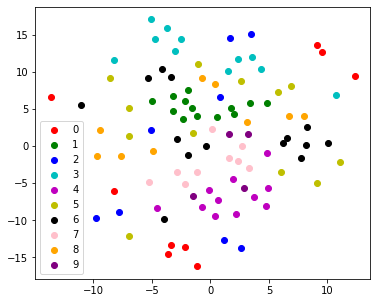

In [98]:

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_2d[Y == i, 0], X_2d[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [180]:
class CNN(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.images = []
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3),#28x28 -> 26x26 (no pad)
            activation_function(),
            nn.MaxPool2d(2, stride = 2), #2x2 maxpool (divide hight and with by 2 -> 13x13)
            nn.Conv2d(6, 10, 3),#(no padding -> 11x11)
            activation_function(),
#            nn.MaxPool2d(2, stride = 2)
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(1210, 150),# (11X11X10 (outchanels))
            activation_function(),
            nn.Linear(150, 50),
            activation_function(),
            nn.Linear(50,10)
        )
    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)# this flattens X before linear layer
        if x.shape[0]<100:
            print(x.shape)
        self.images=(x.detach().numpy())
#         for val in x:
#             self.images.append(val.detach().numpy())
        x = self.linear_lay(x) # bc this is our output layer. No activation here.
        
        return F.softmax(x, dim=1)

In [233]:
import torch.optim as optim

model_untrained = CNN(nn.LeakyReLU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_untrained.parameters(), lr=0.000001)


for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels_untrained = labels
        # zero the parameter gradients
        optimizer.zero_grad()
        #64, 3, 11, 11
        # forward + backward + optimize
        outputs = model_untrained(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
   
    

    
    print(epoch, running_loss)
    
    running_loss = 0.0


0 1105.2349853515625


In [188]:
import torch.optim as optim
model_trained = CNN(nn.LeakyReLU)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_trained.parameters(), lr=0.001)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels_trained = labels
        # zero the parameter gradients
        optimizer.zero_grad()

        #64, 3, 11, 11
        # forward + backward + optimize
        outputs = model_trained(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
   
    

    
    print(epoch, running_loss)
    

0 783.7410198450089
1 729.2866507768631
2 721.3951947689056
3 716.7467658519745
4 713.8032140731812
5 712.9622095823288
6 711.3377277851105
7 709.9472752809525
8 709.723002910614
9 708.8152735233307


In [240]:
print(model_untrained.images.shape)
copy_untrained_data = model_untrained.images

pca = PCA(n_components=2)
pca.fit(copy_untrained_data)
X_untrained_PCA = pca.transform(copy_untrained_data)
print(X_untrained_PCA)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
pca = PCA(n_components=2)
X_untrained = tsne.fit_transform(copy_untrained_data)
numbers = [0,1,2,3,4,5,6,7,8,9]
#print(Xtrained_2d)



(100, 1210)
[[ 0.8870459   0.0370409 ]
 [-0.2972741   0.4574168 ]
 [-0.7519345   0.05601672]
 [ 0.39293557 -0.5803373 ]
 [-0.3339841   0.2091939 ]
 [ 0.254541    0.46333683]
 [ 0.22593814 -0.45430142]
 [ 0.6355411  -0.56617415]
 [ 0.02148591 -0.14178865]
 [-0.23973492 -0.12427898]
 [-0.14069876  0.22438158]
 [ 0.0799744   0.63736546]
 [-0.30924064  0.3873543 ]
 [ 0.24497633  0.26240665]
 [-0.05927    -0.35254568]
 [-0.17876431  0.2384241 ]
 [ 0.4688685   0.0041211 ]
 [ 0.03428273  0.15601711]
 [ 0.4647436  -0.19641007]
 [-0.35451147 -0.14151867]
 [ 0.8206189  -0.31574965]
 [-0.03008206 -0.658033  ]
 [-0.84618807  0.03267817]
 [-0.785109   -0.14529161]
 [-0.47728273 -0.10781795]
 [ 0.48355833 -0.0586093 ]
 [ 0.6525673   0.5691594 ]
 [-0.0610726  -0.65483916]
 [-0.09609646 -0.12372701]
 [-0.14658417  0.07539839]
 [ 0.10756182 -0.164721  ]
 [-0.11262443  0.18236932]
 [-0.10699011 -0.26816708]
 [ 0.81437504  0.43846977]
 [ 0.26693016 -0.5654577 ]
 [-0.23754506 -0.44261006]
 [-0.2839418   0

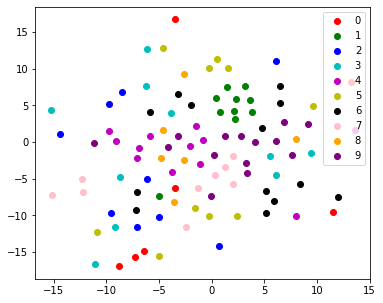

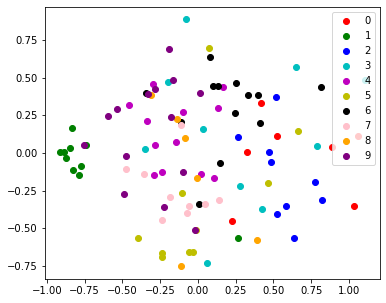

In [236]:

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained[labels_untrained[0:100] == i, 0], X_untrained[labels_untrained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()
plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained_PCA[labels_untrained[0:100] == i, 0], X_untrained_PCA[labels_untrained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [241]:
#tsne_trained2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
print(model_trained.images.shape)
copy_trained_data = model_trained.images

pca.fit(copy_trained_data)
X_trained_PCA = pca.transform(copy_trained_data)

x_trained = tsne.fit_transform(copy_trained_data)



(10, 1210)
[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 12.562855
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.967266
[t-SNE] KL divergence after 300 iterations: 0.338842


In [249]:
plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(x_trained[labels_trained[0:100] == i, 0], x_trained[labels_trained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_trained_PCA[labels_trained[0:100] == i, 0], X_trained_PCA[labels_trained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 100

<Figure size 432x360 with 0 Axes>

In [190]:
def test(model, loader):
    true_labels=[]
    pred_labels=[]
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            image, label = data
            pred = model(image)
            for i in range(len(data)):
                if torch.argmax(pred[i]) == label[i]:
                    correct += 1
                total += 1
    print(" predicted = ", correct/total*100, "% of total ",total)
test(model_untrained,testLoader)
test(model_trained,testLoader)

torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size(

torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size([30, 1210])
torch.Size(